### Import dependencise

In [2]:
# Common
import os 
import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data 
import tensorflow.image as tfi
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [12]:
np.random.seed(2024)
SIZE = 256      # (heigth x width)

In [4]:
classes_colors = pd.read_csv("CamVid\\class_dict.csv")
classes_colors = classes_colors.T
classes_colors

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


### Functions

In [5]:
def show_image(image, title=None, cmap=None, alpha=None):  # alpha = opacity
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    # plt.axis('off')


def load_image(path, SIZE):
    img = load_img(path)
    img = img_to_array(img)
    img = tfi.resize(img, (SIZE, SIZE))
    img = tf.cast(img, tf.float32)      # convert data type to float
    img = img/255.                      # normalize to [0,1]
    return img

### Data Loading

Use sorted(glob()) syntax to visualize in an array the images in the same order that we obtain by opening manually our data folders.

In [6]:
root_path = 'CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [7]:
len(train_image_paths), len(val_image_paths), len(test_image_paths)

(369, 100, 232)

In [8]:
len(train_mask_paths), len(val_mask_paths), len(test_mask_paths)

(369, 100, 232)

In [9]:
# creating null vectors to store the pixel values for each image in an array
train_images = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))
train_masks = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))

val_images = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))
val_masks = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))

test_images = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))
test_masks = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))

for i,path in tqdm(enumerate(train_image_paths), desc="Train Images"):
    image = load_image(path, SIZE=SIZE)
    train_images[i] = image

for i,path in tqdm(enumerate(train_mask_paths), desc="Train Masks"):
    image = load_image(path, SIZE=SIZE)
    train_masks[i] = image
    
for i,path in tqdm(enumerate(val_image_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_images[i] = image
    
for i,path in tqdm(enumerate(val_mask_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_masks[i] = image

for i,path in tqdm(enumerate(test_image_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_images[i] = image
    
for i,path in tqdm(enumerate(test_mask_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_masks[i] = image

Train Images: 7it [00:00, 16.79it/s]

Train Images: 369it [00:18, 19.50it/s]
Train Masks: 369it [00:18, 20.48it/s]
Valid Masks: 100it [00:04, 21.80it/s]
Valid Masks: 100it [00:03, 30.71it/s]
Test Masks: 232it [00:09, 23.93it/s]
Test Masks: 232it [00:06, 33.82it/s]


Now we have 6 tensors full of pixel information of resized, float type and normalized images.

Let's visualize what we are dealing with.

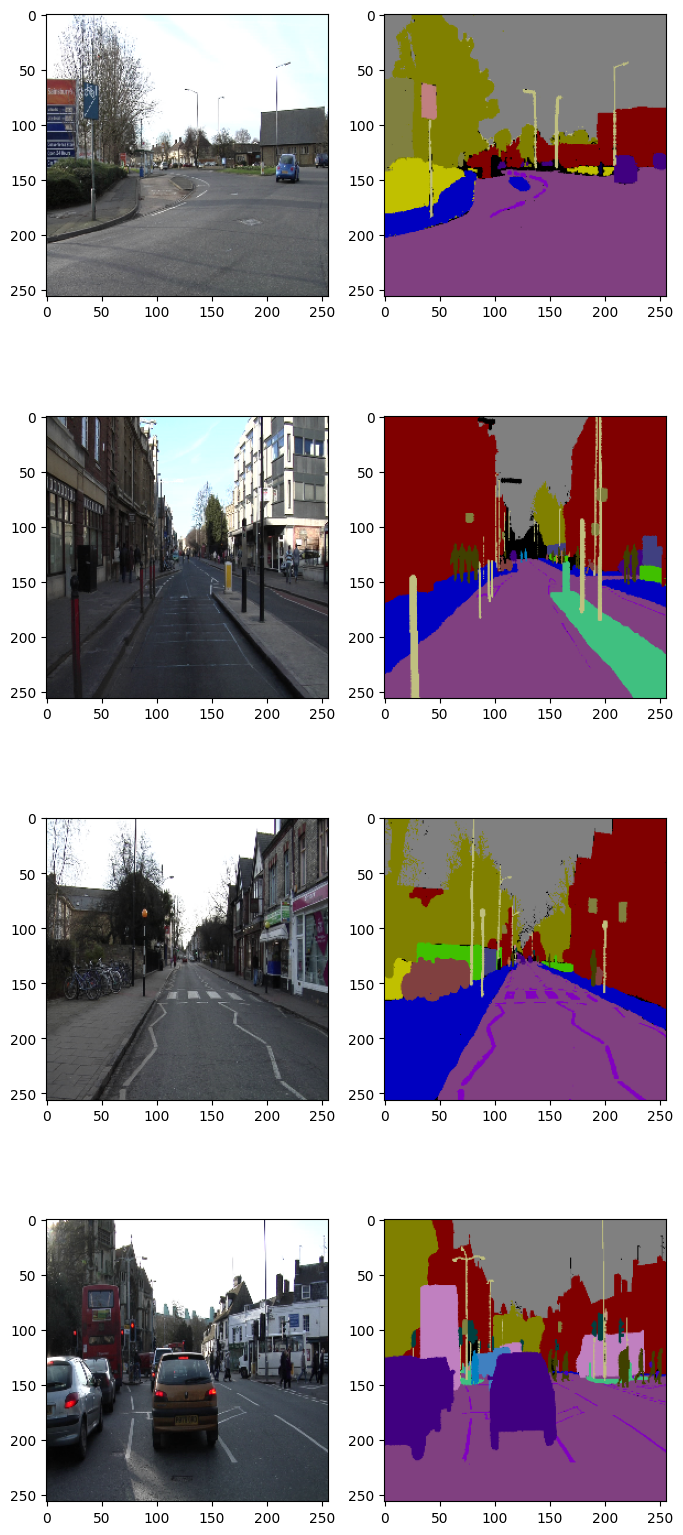

In [14]:
# plot random images paired with their respective mask
plt.figure(figsize=(8,20))
for i in range(8):
    plt.subplot(4,2,i+1)
    if (i+1)%2!=0:
        rand_id = np.random.randint(len(train_image_paths))
        rand_image = train_images[rand_id]
        rand_mask = train_masks[rand_id]
        show_image(rand_image)
    elif (i+1)%2==0:
        show_image(rand_mask)